# Wasserstein GAN

## Outline

* Was wird in dem Notebookbesprochen

## Recap: Vanilla GAN

* Wie functioniert ein Vanilla GAN

In [1]:
from IPython.display import Image
Image(url="https://www.researchgate.net/publication/336781462/figure/fig2/AS:817722363494401@1571971612898/Example-of-a-typical-GANs-architecture-for-both-hand-written-digits-recognition-and.png", width=700)

### Problems

* Probleme eines Vanilla GANs

### Solutions

* Mögliche Lösungen

## Different Distances

In [ ]:
from scipy.stats import wasserstein_distance, norm
import scipy.signal
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd 

from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div


import matplotlib.pyplot as plt

import numpy as np

### Helper Methods

In [ ]:
def get_P(X, mean=0, std=1, decimals=10):
    X_lower_bound, X_upper_bound = X - 0.5, X + 0.5
    P = norm(mean, std).cdf(X_upper_bound) - norm(mean, std).cdf(X_lower_bound)
    P = P / P.sum()
    P = np.round(P, decimals=decimals)
  
    return P

def plot_Px(P, X):
    plt.hist(np.random.choice(X, size=100000, p=P), bins=len(X))

In [ ]:
def plot_Pxs(p_1, x_1, p_2, x_2, lines=False):
    fig = go.Figure()
    data_1 = {
        'x': x_1,
        'y': p_1,
        'name': 'Probability 1',
        #'marker_color': 'rgb(146, 9, 173)'
    }
    
    data_2 = {
        'x': x_2,
        'y': p_2,
        'name': 'Probability 2',
        #'marker_color': 'rgb(97, 18, 189)'
    }

    trace_1 = go.Scatter(data_1) if lines else go.Bar(data_1)
    trace_2 = go.Scatter(data_2) if lines else go.Bar(data_2)

    fig.add_trace(trace_1)
    fig.add_trace(trace_2)

    extra_config = {} if lines else {'barmode': 'group', 'bargap': 0.15, 'bargroupgap': 0.1}
  
    fig.update_layout(
        title='Probability Functions',
        xaxis_tickfont_size=14,
        yaxis=dict(
            title='Probability',
            titlefont_size=16,
            tickfont_size=14,
        ),
        legend=dict(
            x=0,
            y=1.0,
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'
        ),
        **extra_config
    )
    
    fig.show()

In [ ]:
def plot_distances(X, D, line=False):
    fig = go.Figure()

    for x, d in zip(X, D):
      data = {
        'x': x,
        'y': d,
      }

      trace = go.Scatter(data) if line else go.Bar(data)
      fig.add_trace(trace)

    extra_config = {} if line else {'barmode': 'group', 'bargap': 0.15, 'bargroupgap': 0.1}
  
    fig.update_layout(
        title='Distances',
        xaxis_tickfont_size=14,
        yaxis=dict(
            title='Distance',
            titlefont_size=16,
            tickfont_size=14,
        ),
        legend=dict(
            x=0,
            y=1.0,
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'
        ),
        **extra_config
    )
    
    fig.show()

In [ ]:
def plot_separate_ps(x_1, x_2, p_1, p_2):
    df = pd.DataFrame({'probability': 1, 'x': x_1, 'y': p_1}).append(pd.DataFrame({'probability': 2, 'x': x_2, 'y': p_2}))
    fig = px.bar(df, x="x", y="y", barmode="group", facet_col="probability")
    fig.show()

In [ ]:
def mat_plot_grouped(x_1, x_2, p_1, p_2):
    X = np.arange(len(range(min(x_1 + x_2), max(x_1 + x_2) + 1)))

    for x in X:
        if x not in x_1:
            i = 0
            while i < len(x_1) - 1 and x_1[i] < x:
                i += 1

            x_1 = x_1[:i] + [x] + x_1[i:]
            p_1 = p_1[:i] + [0.0] + p_1[i:]

        if x not in x_2:
            i = 0
            
            while i < len(x_2) - 1 and x_2[i] < x:
                i += 1

        x_2 = x_2[:i] + [x] + x_2[i:]
        p_2 = p_2[:i] + [0.0] + p_2[i:]

    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(X - width / 2 - 0.01, p_1, width, label='P1')
    rects2 = ax.bar(X + width / 2 + 0.01, p_2, width, label='P2')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Probabilities')
    ax.set_title('Probabilities')
    ax.set_xticks(X)
    ax.set_xticklabels(X)
    ax.legend()

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

In [ ]:
def mat_plot_separate(x_1, x_2, p_1, p_2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Horizontally stacked subplots')
    ax1.bar(x_1, p_1)
    ax2.bar(x_2, p_2)

### Kullback-Leibler Divergence

#### $P_r$ and $P_g$ are joint

In [ ]:
Pr_x = np.arange(-10, 6)
Pr = get_P(Pr_x, -5, 2)
Pr[11:] = 0

Pg_x = np.arange(-10, 6)
Pg = get_P(Pg_x, 0, 2)
Pg[:5] = 0
Pg[16:] = 0

plot_Pxs(Pr, Pr_x, Pg, Pg_x)

In [ ]:
kl_div(Pr, Pg)

array([       inf,        inf,        inf,        inf,        inf,
       0.4174043 , 0.1744795 , 0.018728  , 0.01527972, 0.09599666,
       0.16034543, 0.17518836, 0.12133915, 0.06578665, 0.02791788,
       0.00927234])

In [ ]:
kl_div(Pg, Pr)

array([0.00927234, 0.02791788, 0.06578665, 0.12133915, 0.17518836,
       0.16034543, 0.09599666, 0.01527972, 0.018728  , 0.1744795 ,
       0.4174043 ,        inf,        inf,        inf,        inf,
              inf])

In [ ]:
plot_distances([Pr_x, Pg_x], [kl_div(Pg, Pr), kl_div(Pr, Pg)], line=True)

### Jensen-Shannon Divergence

#### $P_r$ and $P_g$ are joint

In [ ]:
Pr_x = np.arange(-10, 6)
Pr = get_P(Pr_x, -5, 2)
Pr[11:] = 0

Pg_x = np.arange(-10, 6)
Pg = get_P(Pg_x, 0, 2)
Pg[:5] = 0
Pg[16:] = 0

plot_Pxs(Pr, Pr_x, Pg, Pg_x)

In [ ]:
jensenshannon(Pr, Pg)

0.8325546111576977

In [ ]:
jensenshannon(Pg, Pr)

0.8325546111576977

#### $P_r$ and $P_g$ are disjunct.

In [ ]:
Pr_x = np.arange(-10, 11)
Pr = get_P(Pr_x, -5, 1)
Pr[10:] = 0

Pg_x = np.arange(-10, 11)
Pg = get_P(Pg_x, 5, 1)
Pg[:-10] = 0

plot_Pxs(Pr, Pr_x, Pg, Pg_x)

In [ ]:
jensenshannon(Pr, Pg)

0.8325546111576977

### Wassserstein-1 Distance / Earth-Mover Distance

#### $P_r$ and $P_g$ are joint

In [ ]:
Pr_x = np.arange(-10, 6)
Pr = get_P(Pr_x, -5, 2)
Pr[11:] = 0

Pg_x = np.arange(-10, 6)
Pg = get_P(Pg_x, 0, 2)
Pg[:5] = 0
Pg[16:] = 0

plot_Pxs(Pr, Pr_x, Pg, Pg_x)

In [ ]:
wasserstein_distance(Pr_x, Pg_x, Pr, Pg)

5.0

In [ ]:
wasserstein_distance(Pg_x, Pr_x, Pg, Pr)

5.0

## 2. Why Wasserstein Distance?

### When $\theta$ = 1

In [ ]:
Px = np.arange(0, 1.1, 0.1)
P = np.zeros(11) 
P[0] = 1

Qx = np.arange(0, 1.1, 0.1)
Q = np.zeros(11) 
Q[-1] = 1

plot_Pxs(P, Px, Q, Qx)

In [ ]:
kl_div(P, Q)

array([inf,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [ ]:
jensenshannon(P, Q)

0.8325546111576977

In [ ]:
wasserstein_distance(Px, Qx, P, Q)

1.0

### When $\theta$ = 0.5

In [ ]:
Px = np.arange(0, 1.1, 0.1)
P = np.zeros(11) 
P[0] = 1

Qx = np.arange(0, 1.1, 0.1)
Q = np.zeros(11) 
Q[5] = 1

plot_Pxs(P, Px, Q, Qx)

In [ ]:
kl_div(P, Q)

array([inf,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
jensenshannon(P, Q)

0.8325546111576977

In [ ]:
wasserstein_distance(Px, Qx, P, Q)

0.5

### When $\theta$ = 0.0

In [ ]:
Px = np.arange(0, 1.1, 0.1)
P = np.zeros(11) 
P[0] = 1

Qx = np.arange(0, 1.1, 0.1)
Q = np.zeros(11) 
Q[0] = 1

plot_Pxs(P, Px, Q, Qx)

In [ ]:
kl_div(P, Q)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
jensenshannon(P, Q)

0.0

In [ ]:
wasserstein_distance(Px, Qx, P, Q)

0.0

## 3. Empirical Results

In [1]:
import random
import os
import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt

import pickle

### Connect Drive

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

#DRIVE_PATH = "/content/drive/My Drive/security\ &\ ai"
DRIVE_PATH = "./"

### Device

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Random Seed

In [4]:
manualSeed = random.randint(1, 10000)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
manualSeed

6989

## MNIST Dataset

Set general dataset parameters.

In [5]:
BATCH_SIZE = 64
IMAGE_SIZE = 32
N_CHANNELS = 1
N_FEATURES_D = 64
N_FEATURES_G = 64
N_Z = 100

Load dataset and prepare dataloader for training.

In [6]:
mnist = datasets.MNIST(
    f"{DRIVE_PATH}/data/mnist", download=True, train=True, 
    transform=transforms.Compose(
        [
         transforms.Resize(IMAGE_SIZE), 
         transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ]
    )
)

mnist = torch.utils.data.DataLoader(
    mnist, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

Plot dataset examples.

In [7]:
def plot_examples(dataloader, n_examples=16):
    _, (data, targets) = next(enumerate(dataloader))
    fig = plt.figure(figsize=(10, 10))
    
    for i in range(n_examples):
        plt.subplot(math.ceil(n_examples / 4), 4, i + 1)
        plt.tight_layout()
        plt.imshow(data[i][0], cmap='gray', interpolation='none')
        plt.title(f"Ground Truth: {targets[i]}")
        plt.xticks([])
        plt.yticks([])

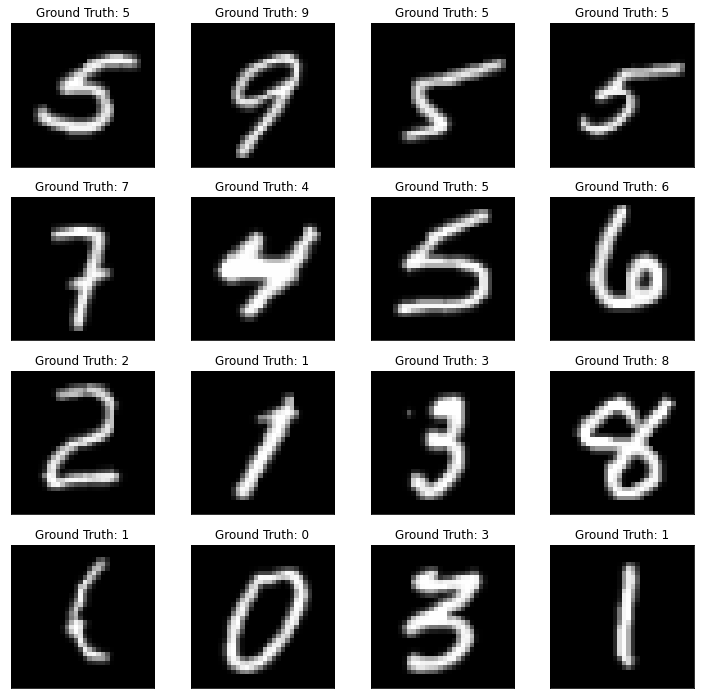

In [8]:
plot_examples(mnist)

## Models: MLP and DC GAN

Define general DC GAN architecture for discriminator. 

In [60]:
class MLP_GAN_Discriminator(nn.Module):
    def __init__(self, image_size=IMAGE_SIZE, n_channels=N_CHANNELS, n_features=N_FEATURES_D, wasserstein=True):
        super(MLP_GAN_Discriminator, self).__init__()

        self.image_size = image_size
        self.n_channels = n_channels
        self.wasserstein = wasserstein

        self.layers = nn.Sequential(
            nn.Linear(n_channels * image_size * image_size, n_features),
            nn.ReLU(True),
            nn.Linear(n_features, n_features),
            nn.ReLU(True),
            nn.Linear(n_features, n_features),
            nn.ReLU(True),
            nn.Linear(n_features, 1),
        )
        
        if not wasserstein:
            self.layers.add_module('final:{0}:sigmod'.format(n_channels),
                        nn.Sigmoid())

    def forward(self, input):
        input = input.view(-1, self.n_channels * self.image_size * self.image_size)
        
        output = self.layers(input)
        
        if self.wasserstein:
            output = output.mean(0).view(-1)
        else:
            output = output.view(-1, 1)

        return output
    
class MLP_GAN_Generator(nn.Module):
    def __init__(self, image_size=IMAGE_SIZE, n_channels=N_CHANNELS, n_z=N_Z, n_features=N_FEATURES_G):
        super(MLP_GAN_Generator, self).__init__()

        self.image_size = image_size
        self.n_channels = n_channels
        self.n_z = n_z

        self.layers = nn.Sequential(
            nn.Linear(n_z, n_features),
            nn.ReLU(True),
            nn.Linear(n_features, n_features),
            nn.ReLU(True),
            nn.Linear(n_features, n_features),
            nn.ReLU(True),
            nn.Linear(n_features, n_channels * image_size * image_size),
        )

    def forward(self, input):
        input = input.view(-1, self.n_z)
        output = self.layers(input)
        return output.view(-1, self.n_channels, self.image_size, self.image_size)

In [61]:
class DC_GAN_Discriminator(nn.Module):
    def __init__(self, image_size=IMAGE_SIZE, n_channels=N_CHANNELS, n_features=N_FEATURES_D, wasserstein=True):
        super(DC_GAN_Discriminator, self).__init__()

        self.wasserstein = wasserstein

        layers = [
            self.block(n_channels, n_features, batch_norm=False),
            self.block(n_features, n_features * 2),
            self.block(n_features * 2, n_features * 4),
            nn.Conv2d(n_features * 4, 1, 4, 1, 0, bias=False)
        ]

        if not wasserstein:
            layers.append(nn.Sigmoid())

        self.layers = nn.Sequential(*layers)

    @staticmethod
    def block(in_features, out_features, batch_norm=True):
        layers = [nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False)]

        if batch_norm:
            layers.append(nn.BatchNorm2d(out_features))

        layers.append(nn.LeakyReLU(0.2, inplace=True))

        return nn.Sequential(*layers)

    def forward(self, input):
        output = self.layers(input)

        if self.wasserstein:
            output = output.mean(0).view(-1)
        else:
            output = output.view(-1, 1)

        return output


class DC_GAN_Generator(nn.Module):
    def __init__(self, image_size=IMAGE_SIZE, n_channels=N_CHANNELS, n_z=N_Z, n_features=N_FEATURES_G):
        super(DC_GAN_Generator, self).__init__()

        self.image_size = image_size
        self.n_z = n_z

        n_features = n_features // 2 * 8  # 256

        self.layers = nn.Sequential(
            self.block(n_z, n_features, 1, 0),
            self.block(n_features, n_features // 2),
            self.block(n_features // 2, n_features // 4),
            nn.ConvTranspose2d(n_features // 4, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    @staticmethod
    def block(in_features, out_features, stride=2, padding=1):
        return nn.Sequential(
            nn.ConvTranspose2d(in_features, out_features, 4, stride, padding, bias=False),
            nn.BatchNorm2d(out_features),
            nn.ReLU(True)
        )

    def forward(self, input):
        return self.layers(input) 

Define general DC_GAN architecture for generator. 

## Models: Weight Initialization

Define general DC_GAN weight initialization. 

In [62]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## Training

In [72]:
LEARNING_RATE = 0.00005

CLAMP_LOWER = -0.01
CLAMP_UPPER = 0.01

MIN_ITERARTINS_D_WASSERSTEIN = 5
MAX_ITERATIONS_D_WASSERSTEIN = 100

MIN_ITERARTINS_D_VANILLA = 1
MAX_ITERATIONS_D_VANILLA = 1

EPOCHS = 50

In [64]:
def noise(n, n_z, device):
    return torch.randn((n, n_z, 1, 1), device=device)

def sample(n, generator, device):
    return generator(noise(n, generator.n_z, device))

Define general training process. 

In [65]:
def train_d(discriminator, generator, real_images, fake_images, real_labels, fake_labels, batch_size, optimizer_d, criterion,
            wasserstein, one, minus_one, clamp_lower, clamp_upper, device):
    discriminator.zero_grad()

    if wasserstein:
        for parameter in discriminator.parameters():
            parameter.data.clamp_(clamp_lower, clamp_upper)

    output_d_real = discriminator(real_images)

    if wasserstein:
        loss_d_real = output_d_real
        loss_d_real.backward(one)
    else:
        loss_d_real = criterion(output_d_real, real_labels)

    output_d_fake = discriminator(fake_images.detach())

    if wasserstein:
        loss_d_fake = output_d_fake
        loss_d_fake.backward(minus_one)
        loss_d = loss_d_fake - loss_d_real
    else:
        loss_d_fake = criterion(output_d_fake, fake_labels)
        loss_d = loss_d_real + loss_d_fake
        loss_d.backward()

    optimizer_d.step()

    return loss_d.item()

def train_g(discriminator, generator, fake_images, real_labels, batch_size, optimizer_g, criterion, wasserstein, one, minus_one,
            device):
    generator.zero_grad()

    output_d_fake = discriminator(fake_images)

    if wasserstein:
        loss_g = output_d_fake
        loss_g.backward(one)
    else:
        loss_g = criterion(output_d_fake, real_labels)
        loss_g.backward()

    optimizer_g.step()

    return loss_g.item()

In [66]:
def train(
        dataloader, discriminator, generator, optimizer_d, optimizer_g, criterion=None, image_size=IMAGE_SIZE,
        n_c=N_CHANNELS, n_z=N_Z,
        batch_size=BATCH_SIZE, min_iterations_d=MIN_ITERARTINS_D_WASSERSTEIN,
        max_iterations_d=MAX_ITERATIONS_D_WASSERSTEIN, epochs=EPOCHS, clamp_lower=CLAMP_LOWER, clamp_upper=CLAMP_UPPER,
        wasserstein=True,
        device=torch.device("cpu"), save_path="./output"
):
    train_stats = TrainingStatistics(epochs, len(dataloader), noise(batch_size, n_z, device), save_path)

    discriminator.to(device)
    generator.to(device)
    
    if wasserstein:
        one = torch.FloatTensor([1]).to(device)
        minus_one = torch.FloatTensor([-1]).to(device)
    else:
        one, minus_one = None, None
        criterion.to(device)

    iterations_g = 0
    iterations_d = 0

    for epoch in range(epochs):
        for batch_index, (real_images, _) in enumerate(dataloader):
            batch_size = len(real_images)

            real_images = real_images.to(device)
            fake_images = sample(batch_size, generator, device)

            real_labels = torch.ones((batch_size, 1), device=device)
            fake_labels = torch.zeros((batch_size, 1), device=device)

            if iterations_d == 0:
                iterations_d = max_iterations_d if iterations_g < 25 or iterations_g % 500 == 0 else min_iterations_d

            loss_d = train_d(discriminator, generator, real_images, fake_images, real_labels, fake_labels, batch_size,
                             optimizer_d, criterion, wasserstein, one, minus_one, clamp_lower, clamp_upper, device)
            iterations_d -= 1

            if iterations_d == 0:
                loss_g = train_g(discriminator, generator, fake_images, real_labels, batch_size, optimizer_g, criterion,
                                 wasserstein, one, minus_one, device)
                iterations_g += 1
        
        train_stats.finish_epoch(discriminator, generator, loss_d, loss_g, iterations_g)   

    return train_stats

In [67]:
class TrainingStatistics:
    def __init__(self, epochs, batches, fixed_z, save_path="./output"):
        self.epochs = epochs
        self.batches = batches

        self.losses_d = []
        self.mean_losses_d = []
        self.losses_g = []
        self.mean_losses_g = []

        self.iterations_g = []

        os.makedirs(save_path, exist_ok=True)
        self.save_path = save_path

        self.fixed_z = fixed_z
        self.fixed_z.requires_grad = False

    def finish_epoch(self, discriminator, generator, loss_d, loss_g, iterations_g):
        self.losses_d.append(loss_d)
        self.mean_losses_d.append(torch.mean(torch.FloatTensor(self.losses_d)))

        self.losses_g.append(loss_g)
        self.mean_losses_g.append(torch.mean(torch.FloatTensor(self.losses_g)))

        self.iterations_g.append(iterations_g)

        self.print()
        self.save_models(discriminator, generator)
        self.save_images(generator)
        self.save_hist()

    def print(self):
        print(
            f"[{len(self.losses_d)}/{self.epochs}][{self.iterations_g[-1]:d}] Loss D: {self.losses_d[-1]:f} Loss G: {self.losses_g[-1]:f}")

    def plot_hist(self):
        x = train_stats.iterations_g
        y1 = train_stats.mean_losses_d
        y2 = train_stats.mean_losses_g

        plt.plot(x, y1, label='D mean loss')
        plt.plot(x, y2, label='G mean loss')

        plt.xlabel('G Iterations')
        plt.ylabel('Loss')

        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()

        plt.show()
        
    def plot_fake_images(self):
        fake_images = plt.imread(f"{self.save_path}/fake_images_{self.iterations_g[-1]}.png")
        fig = plt.figure(figsize=(10, 10))
        fig, (axis) = plt.subplots(1, 1)
        axis.imshow(fake_images, cmap='gray')

    def hist(self):
        return {
            'D loss': self.losses_d,
            'D mean loss': self.mean_losses_d,
            'G loss': self.losses_g,
            'G mean loss': self.mean_losses_g,
            'G Iterations': self.iterations_g,
        }

    def save_models(self, discriminator, generator):
        torch.save(discriminator.state_dict(), f'{self.save_path}/discriminator.pth')
        torch.save(generator.state_dict(), f'{self.save_path}/generator.pth')

    def save_images(self, generator):
        fake_images = generator(self.fixed_z)
        save_image(
            self.denormalize_image(fake_images.data).view(-1, 1, generator.image_size, generator.image_size),
            f'{self.save_path}/fake_images_{self.iterations_g[-1]}.png'
        )

    def save_hist(self):
        with open(f'{self.save_path}/hist.pkl', 'wb') as file:
            pickle.dump(self.hist(), file)

    @staticmethod
    def denormalize_image(image):
        return image.mul(0.5).add(0.5)

Define general plotting of training results. 

## Wasserstein MLP GAN

In [68]:
SAVE_PATH_W_MLP_GAN = f"{DRIVE_PATH}/output/w_mlp_gan"

Define Wasserstein MLP GAN discriminator. 

In [69]:
# Initialize discriminator model
discriminator = MLP_GAN_Discriminator()

# Apply weights initialization
discriminator.apply(weights_init)

# Load saved discriminator checkpoint (optional)
# discriminator.load_state_dict(torch.load(f'{SAVE_PATH_W_MLP_GAN}/discriminator.pth'))

# Plot discriminator model architecture
print(discriminator)

MLP_GAN_Discriminator(
  (layers): Sequential(
    (0): Linear(in_features=1024, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


Define Wasserstein MLP GAN for generator. 

In [70]:
# Initialize generator model
generator = MLP_GAN_Generator()

# Apply weights initialization
generator.apply(weights_init)

# Load saved generator checkpoint (optional)
# generator.load_state_dict(torch.load(f'{SAVE_PATH_W_MLP_GAN}/generator.pth'))

# Plot generator model architecture
print(generator)

MLP_GAN_Generator(
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=64, out_features=1024, bias=True)
  )
)


Define Root Mean Squared Propagation (RMSprop) optimizers for training.

In [73]:
# Initialize discriminator RMSprop optimizer
optimizer_d = optim.RMSprop(discriminator.parameters(), lr=LEARNING_RATE)

# Initialize generator RMSprop optimizer
optimizer_g = optim.RMSprop(generator.parameters(), lr=LEARNING_RATE)

Train Wasserstein MLP GAN models.

In [74]:
# Train models; Returns a loss histogram that shows the training progess
train_stats = train(
    mnist, discriminator, generator, optimizer_d, optimizer_g, device=device, save_path=SAVE_PATH_W_MLP_GAN
)

[1/50][9] Loss D: 0.240814 Loss G: -0.004237
[2/50][18] Loss D: 0.266617 Loss G: -0.004898
[3/50][87] Loss D: 0.276105 Loss G: -0.007592
[4/50][275] Loss D: 0.129665 Loss G: -0.101255
[5/50][463] Loss D: 0.011961 Loss G: 0.000137
[6/50][631] Loss D: 0.020563 Loss G: -0.007312
[7/50][819] Loss D: 0.019328 Loss G: -0.002228
[8/50][1000] Loss D: 0.026332 Loss G: -0.003508
[9/50][1175] Loss D: 0.028299 Loss G: -0.009197
[10/50][1363] Loss D: 0.023458 Loss G: -0.004015
[11/50][1531] Loss D: 0.028800 Loss G: -0.013027
[12/50][1719] Loss D: 0.020834 Loss G: -0.009696
[13/50][1906] Loss D: 0.013980 Loss G: -0.009074
[14/50][2075] Loss D: 0.017924 Loss G: -0.006749
[15/50][2263] Loss D: 0.018502 Loss G: -0.000614
[16/50][2450] Loss D: 0.018008 Loss G: -0.009153
[17/50][2619] Loss D: 0.026288 Loss G: -0.010882
[18/50][2806] Loss D: 0.023128 Loss G: -0.003345
[19/50][2994] Loss D: 0.028857 Loss G: -0.008532
[20/50][3163] Loss D: 0.020997 Loss G: 0.001547
[21/50][3350] Loss D: 0.020161 Loss G: -0.

Plot histogram results of Wasserstein MLP GAN training.

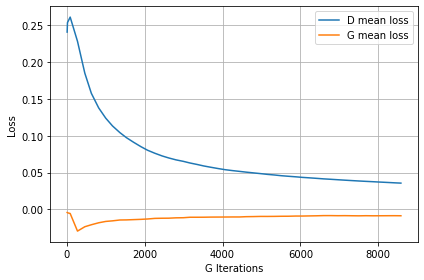

In [75]:
# Plot results
train_stats.plot_hist()

Show resulting fake images.

<Figure size 720x720 with 0 Axes>

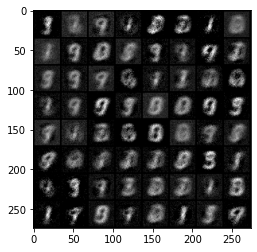

In [76]:
# Show fake samples.
train_stats.plot_fake_images()

## Wasserstein DC GAN

In [77]:
SAVE_PATH_W_DC_GAN = f"{DRIVE_PATH}/output/w_dc_gan"

Define Wasserstein DC GAN discriminator. 

In [78]:
# Initialize discriminator model
discriminator = DC_GAN_Discriminator()

# Apply weights initialization
discriminator.apply(weights_init)

# Load saved discriminator checkpoint (optional)
# discriminator.load_state_dict(torch.load(f'{SAVE_PATH_W_DC_GAN}/discriminator.pth'))

# Plot discriminator model architecture
print(discriminator)

DC_GAN_Discriminator(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


Define Wasserstein DC GAN for generator. 

In [79]:
# Initialize generator model
generator = DC_GAN_Generator()

# Apply weights initialization
generator.apply(weights_init)

# Load saved generator checkpoint (optional)
# generator.load_state_dict(torch.load(f'{SAVE_PATH_W_DC_GAN}/generator.pth'))

# Plot generator model architecture
print(generator)

DC_GAN_Generator(
  (layers): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): Tanh()
  )
)


Define Root Mean Squared Propagation (RMSprop) optimizers for training.

In [80]:
# Initialize discriminator RMSprop optimizer
optimizer_d = optim.RMSprop(discriminator.parameters(), lr=LEARNING_RATE)

# Initialize generator RMSprop optimizer
optimizer_g = optim.RMSprop(generator.parameters(), lr=LEARNING_RATE)

Train Wasserstein DC GAN models.

In [81]:
# Train models; Returns a loss histogram that shows the training progess
train_stats = train(
    mnist, discriminator, generator, optimizer_d, optimizer_g, device=device, save_path=SAVE_PATH_W_DC_GAN
)

[1/50][9] Loss D: 0.711758 Loss G: 0.352121
[2/50][18] Loss D: 0.706228 Loss G: 0.345480
[3/50][87] Loss D: 0.619544 Loss G: 0.320221
[4/50][275] Loss D: 0.667810 Loss G: 0.331325
[5/50][463] Loss D: 0.573524 Loss G: 0.293548
[6/50][631] Loss D: 0.443514 Loss G: 0.230243
[7/50][819] Loss D: 0.358974 Loss G: 0.203780
[8/50][1000] Loss D: 0.328227 Loss G: 0.134219
[9/50][1175] Loss D: 0.363863 Loss G: 0.143915
[10/50][1363] Loss D: 0.318119 Loss G: 0.128823
[11/50][1531] Loss D: 0.297122 Loss G: 0.202962
[12/50][1719] Loss D: 0.293632 Loss G: 0.123725
[13/50][1906] Loss D: 0.232348 Loss G: 0.157018
[14/50][2075] Loss D: 0.271074 Loss G: 0.156871
[15/50][2263] Loss D: 0.232483 Loss G: 0.193187
[16/50][2450] Loss D: 0.231333 Loss G: 0.051083
[17/50][2619] Loss D: 0.220672 Loss G: 0.154237
[18/50][2806] Loss D: 0.206597 Loss G: 0.171747
[19/50][2994] Loss D: 0.225058 Loss G: 0.035807
[20/50][3163] Loss D: 0.199810 Loss G: 0.053907
[21/50][3350] Loss D: 0.190812 Loss G: 0.156177
[22/50][3519

Plot histogram results of Wasserstein DC GAN training.

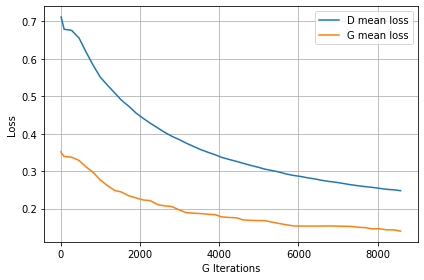

In [82]:
# Plot results
train_stats.plot_hist()

Show resulting fake images.

<Figure size 720x720 with 0 Axes>

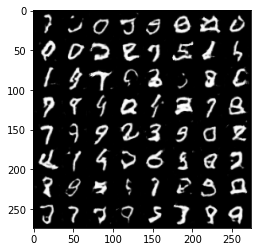

In [83]:
# Show fake samples.
train_stats.plot_fake_images()

## Vanilla MLP GAN

In [31]:
SAVE_PATH_V_MLP_GAN = f"{DRIVE_PATH}/output/v_mlp_gan"

Define Vanilla MLP discriminator. 

In [32]:
# Initialize discriminator model
discriminator = MLP_GAN_Discriminator(wasserstein=False)

# Apply weights initialization
discriminator.apply(weights_init)

# Load saved discriminator checkpoint (optional)
# discriminator.load_state_dict(torch.load(f'{SAVE_PATH_V_MLP_GAN}/discriminator.pth'))

# Plot discriminator model architecture
print(discriminator)

MLP_Discriminator(
  (layers): Sequential(
    (0): Linear(in_features=1024, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (final:1:sigmod): Sigmoid()
  )
)


Define Vanilla MLP generator.

In [33]:
# Initialize generator model
generator = MLP_GAN_Generator()

# Apply weights initialization
generator.apply(weights_init)

# Load saved generator checkpoint (optional)
# generator.load_state_dict(torch.load(f'{SAVE_PATH_V_MLP_GAN}/generator.pth'))

# Plot generator model architecture
print(generator)

MLP_Generator(
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=64, out_features=1024, bias=True)
  )
)


Define Root Mean Squared Propagation (RMSprop) optimizers for training.

In [34]:
# Initialize discriminator RMSprop optimizer
optimizer_d = optim.RMSprop(discriminator.parameters(), lr=LEARNING_RATE)

# Initialize generator RMSprop optimizer
optimizer_g = optim.RMSprop(generator.parameters(), lr=LEARNING_RATE)

Initialize BCELoss as criterion.

In [35]:
criterion = nn.BCELoss()

Plot histogram results of Vanilla DC GAN training.

In [36]:
# Train models; Returns training statistics that shows the training progess
train_stats = train(
    mnist, discriminator, generator, optimizer_d, optimizer_g, min_iterations_d=MIN_ITERARTINS_D_VANILLA,
    max_iterations_d=MAX_ITERATIONS_D_VANILLA, device=device, save_path=SAVE_PATH_V_MLP_GAN, criterion=criterion, 
    wasserstein=False
)

[1/50][938] Loss D: 1.409338 Loss G: 0.900692
[2/50][1876] Loss D: 0.751006 Loss G: 1.097246
[3/50][2814] Loss D: 0.529324 Loss G: 1.927446
[4/50][3752] Loss D: 0.030911 Loss G: 3.935533
[5/50][4690] Loss D: 0.866507 Loss G: 1.556063
[6/50][5628] Loss D: 1.074644 Loss G: 1.615668
[7/50][6566] Loss D: 0.850856 Loss G: 1.599197
[8/50][7504] Loss D: 0.641360 Loss G: 2.030917
[9/50][8442] Loss D: 1.047527 Loss G: 1.259212
[10/50][9380] Loss D: 1.540600 Loss G: 1.183924
[11/50][10318] Loss D: 1.257946 Loss G: 2.694448
[12/50][11256] Loss D: 0.320979 Loss G: 1.615994
[13/50][12194] Loss D: 2.161940 Loss G: 0.760006
[14/50][13132] Loss D: 1.336603 Loss G: 1.944247
[15/50][14070] Loss D: 1.278397 Loss G: 2.049994
[16/50][15008] Loss D: 1.600087 Loss G: 1.072505
[17/50][15946] Loss D: 1.439280 Loss G: 0.679071
[18/50][16884] Loss D: 1.046822 Loss G: 2.037247
[19/50][17822] Loss D: 0.935816 Loss G: 1.128306
[20/50][18760] Loss D: 1.084060 Loss G: 1.914515
[21/50][19698] Loss D: 0.996004 Loss G: 

Plot histogram results of Vanilla MLP GAN training.

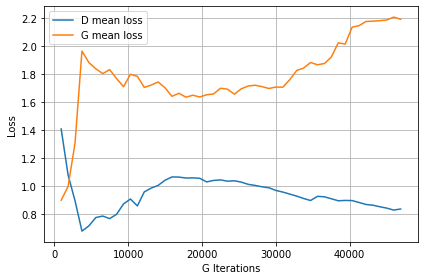

In [37]:
# Plot results
train_stats.plot_hist()

Show resulting fake images.

<Figure size 720x720 with 0 Axes>

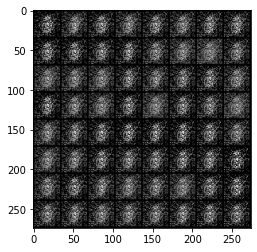

In [38]:
# Show fake samples.
train_stats.plot_fake_images()

## Vanilla DC GAN

In [39]:
SAVE_PATH_V_DC_GAN = f"{DRIVE_PATH}/output/v_dc_gan"

Define Vanilla DC GAN discriminator. 

In [40]:
# Initialize discriminator model
discriminator = DC_GAN_Discriminator(wasserstein=False) 

# Apply weights initialization
discriminator.apply(weights_init)

# Load saved discriminator checkpoint (optional)
# discriminator.load_state_dict(torch.load(f'{SAVE_PATH_V_DC_GAN}/discriminator.pth'))

# Plot discriminator model architecture
print(discriminator)

DCGAN_Discriminator(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (4): Sigmoid()
  )
)


Define Vanilla DC GAN generator.

In [41]:
# Initialize generator model
generator = DC_GAN_Generator()

# Apply weights initialization
generator.apply(weights_init)

# Load saved generator checkpoint (optional)
# generator.load_state_dict(torch.load(f'{SAVE_PATH_V_DC_GAN}/generator.pth'))

# Plot generator model architecture
print(generator)

DCGAN_Generator(
  (layers): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): Tanh()
  )
)


Define Root Mean Squared Propagation (RMSprop) optimizers for training.

In [42]:
# Initialize discriminator RMSprop optimizer
optimizer_d = optim.RMSprop(discriminator.parameters(), lr=LEARINING_RATE)

# Initialize generator RMSprop optimizer
optimizer_g = optim.RMSprop(generator.parameters(), lr=LEARINING_RATE)

Initialize BCELoss as criterion.

In [43]:
criterion = nn.BCELoss()

Train Vanilla DC GAN models.

In [45]:
# Train models; Returns training statistics that shows the training progess
train_stats = train(
    mnist, discriminator, generator, optimizer_d, optimizer_g, min_iterations_d=MIN_ITERARTINS_D_VANILLA,
    max_iterations_d=MAX_ITERATIONS_D_VANILLA, device=device, save_path=SAVE_PATH_V_DC_GAN, criterion=criterion, 
    wasserstein=False
)

[1/50][938] Loss D: 0.155030 Loss G: 2.904615
[2/50][1876] Loss D: 0.184753 Loss G: 3.173557
[3/50][2814] Loss D: 0.159107 Loss G: 3.073726
[4/50][3752] Loss D: 0.146713 Loss G: 3.256948
[5/50][4690] Loss D: 0.206200 Loss G: 2.717762
[6/50][5628] Loss D: 0.077310 Loss G: 3.816779
[7/50][6566] Loss D: 0.183170 Loss G: 3.095915
[8/50][7504] Loss D: 0.131768 Loss G: 3.163477
[9/50][8442] Loss D: 0.100547 Loss G: 3.852509
[10/50][9380] Loss D: 0.114077 Loss G: 3.290453
[11/50][10318] Loss D: 0.025464 Loss G: 5.129134
[12/50][11256] Loss D: 0.059658 Loss G: 4.458539
[13/50][12194] Loss D: 0.028796 Loss G: 4.931079
[14/50][13132] Loss D: 0.018765 Loss G: 5.234098
[15/50][14070] Loss D: 0.039381 Loss G: 4.975050
[16/50][15008] Loss D: 0.013177 Loss G: 6.077506
[17/50][15946] Loss D: 0.026551 Loss G: 4.229637
[18/50][16884] Loss D: 0.013506 Loss G: 7.045795
[19/50][17822] Loss D: 0.352312 Loss G: 3.125139
[20/50][18760] Loss D: 0.289895 Loss G: 3.399043
[21/50][19698] Loss D: 0.005245 Loss G: 

Plot histogram results of Vanilla DC GAN training.

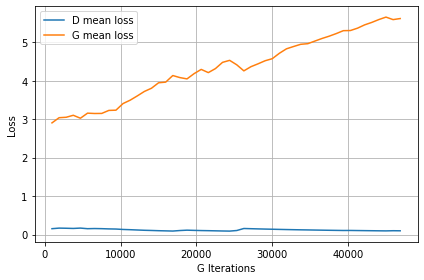

In [46]:
# Plot results
train_stats.plot_hist()

Show resulting fake images.

<Figure size 720x720 with 0 Axes>

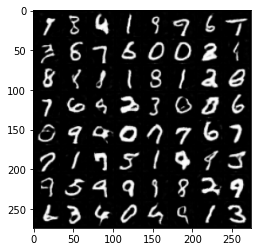

In [47]:
# Show fake samples.
train_stats.plot_fake_images()